# Recurrent Neural Network Benchmark
This experiment will calculate a benchmark for Recurrent Neural Networks. We will use a simple standard for this, so that we know how these networks perform before any tuning or modification.

LSTMs have been used in previous experiments, however this is the first one to use them on a substantial amount of data. For this reason we will treat this as our benchmark.

In [1]:
from exp8_feature_extraction import get_balanced_dataset
from scripts.cross_validate import run_cross_validate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.activations import sigmoid

import numpy as np
import gensim

import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
all_reviews = get_balanced_dataset()

In [3]:
reviews_contents = [x.review_content for x in all_reviews]
labels = [1 if x.label else 0 for x in all_reviews]

In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews_contents)

In [ ]:
corpus_words = tokenizer.word_index
corpus_vocab_size = len(corpus_words)+1

We create sequences necessary to compute word vectors from our embedding matrix:

In [ ]:
predictors_sequences = pad_sequences(tokenizer.texts_to_sequences(reviews_contents))
max_len = max([len(x) for x in predictors_sequences])

We use pretrained word2vec vectors from Google, trained on a Google News corpus:

In [ ]:
word_vectors = gensim.models.KeyedVectors.load_word2vec_format("../../data/GoogleNews-vectors-negative300.bin",
                                                               binary=True)

In [ ]:
embedding_length = word_vectors.vector_size
embedding_matrix = np.zeros((corpus_vocab_size, embedding_length))
for word, index in corpus_words.items():
  if word in word_vectors.vocab:
    embedding_matrix[index] = np.array(word_vectors[word], dtype=np.float32)

Our LSTM model is basic. A similar experiment was ran in a distributed form (outside of this notebook) with 512 units in the LSTM. This experiment was consistently less accurate, so the 10 units here remain.

In [ ]:
def get_lstm_wv_model():
  model = Sequential([
        Embedding(corpus_vocab_size, embedding_length, weights=[embedding_matrix], input_length=max_len, trainable=False),
        LSTM(10),
        Dense(1, activation=sigmoid)
  ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
rnn_wv_scores = run_cross_validate(get_lstm_wv_model, predictors_sequences, labels, cv=5, verbose=1, epochs=12, batch_size=64, shuffle=True)
print(rnn_wv_scores)

Fitting with:  (128745, 997) labels (128745,)
Train on 90121 samples, validate on 38624 samples
Epoch 1/12
90121/90121 [==============================] - 1434s 16ms/step - loss: 0.6397 - acc: 0.6389 - val_loss: 0.6219 - val_acc: 0.6596
Epoch 2/12
90121/90121 [==============================] - 1431s 16ms/step - loss: 0.6150 - acc: 0.6675 - val_loss: 0.6103 - val_acc: 0.6701
Epoch 3/12
90121/90121 [==============================] - 1434s 16ms/step - loss: 0.6011 - acc: 0.6792 - val_loss: 0.6039 - val_acc: 0.6761
Epoch 4/12
90121/90121 [==============================] - 1434s 16ms/step - loss: 0.5923 - acc: 0.6852 - val_loss: 0.5977 - val_acc: 0.6772
Epoch 5/12
90121/90121 [==============================] - 1436s 16ms/step - loss: 0.5847 - acc: 0.6916 - val_loss: 0.6009 - val_acc: 0.6778
Epoch 6/12
90121/90121 [==============================] - 1433s 16ms/step - loss: 0.5794 - acc: 0.6942 - val_loss: 0.6030 - val_acc: 0.6742
Epoch 7/12
90121/90121 [==============================] - 1438s 

In [2]:
rnn_wv_scores

{'accuracies': [0.6950416304360891,
  0.6982105132199318,
  0.6912513980809777,
  0.6904436436383283,
  0.688020380302973,
  0.6965950043790753,
  0.69551979126172,
  0.6962465821970704,
  0.6913373104944592,
  0.6882301764407621],
 'auc': [0.7641,
  0.7698,
  0.7581,
  0.7606,
  0.7578,
  0.7668,
  0.7589,
  0.7611,
  0.7648,
  0.7575],
 'f1-score': [0.7090406606652744,
  0.6914587143164652,
  0.6814917250421457,
  0.6764793394810964,
  0.6912317193856635,
  0.6833695730645123,
  0.6867502117434023,
  0.7083452098884602,
  0.7021526072471556,
  0.6959992215137354]}

Text(0.5, 1.0, 'Recurrent Neural Network Accuracies')

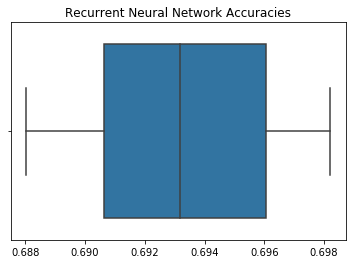

In [4]:
from seaborn import boxplot
from pandas import DataFrame
boxplot(DataFrame([rnn_wv_scores['accuracies']])).set_title("Recurrent Neural Network Accuracies")

Text(0.5, 1.0, 'Recurrent Neural Network AUC scores')

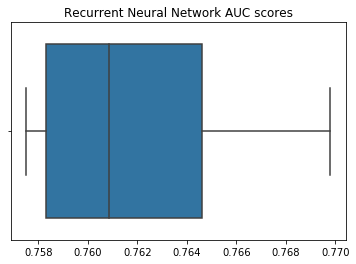

In [5]:
boxplot(DataFrame([rnn_wv_scores['auc']])).set_title("Recurrent Neural Network AUC scores")

Text(0.5, 1.0, 'Recurrent Neural Network F1 scores')

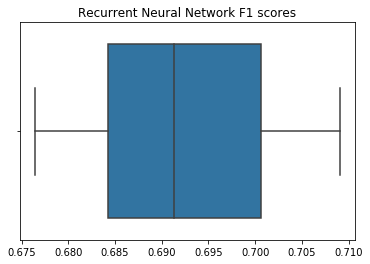

In [7]:
boxplot(DataFrame([rnn_wv_scores['f1-score']])).set_title("Recurrent Neural Network F1 scores")

These accuracies are higher than all previous neural benchmarking experiments. They are reliably between 68% and 70%, meaning that we can treat this as a benchmark for LSTM networks. Future modifications to the model can be compared to this to assess their effects.